In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def zp_model(tp, ha, Tc):
    """Model equation: zp = ha * ln(tp / Tc)"""
    return ha * np.log(tp / Tc)

def fit_ha_Tc(exposure_times, measured_zp_means):
    """
    Fit the zp = ha * ln(tp / Tc) model to the data.
    
    Parameters:
    - exposure_times: list or np.array of exposure times (tp)
    - measured_zp_means: list or np.array of mean measured cured depths (zp)
    
    Returns:
    - ha: Penetration depth
    - Tc: Critical exposure time
    """
    # Initial guesses for ha and Tc
    initial_guess = [40.0, 0.3]  # Just example guesses
    # Curve fitting
    popt, _ = curve_fit(zp_model, exposure_times, measured_zp_means, p0=initial_guess)
    ha, Tc = popt
    return ha, Tc


def plot_fit_with_error_bars(exposure_times, measured_zp_data, ha, Tc, 
                            overlay_exposure_times=None, overlay_zp_data=None, 
                            overlay_color='green'):
    # Calculate means and standard deviations for each exposure time
    zp_means = np.mean(measured_zp_data, axis=1)
    zp_stds = np.std(measured_zp_data, axis=1)
    
    tp_fine = np.linspace(min(exposure_times), max(exposure_times), 200)
    zp_fit = zp_model(tp_fine, ha, Tc)

    plt.figure(figsize=(10, 6))
    # Plot individual measurements as scatter points
    for i, exp_time in enumerate(exposure_times):
        plt.scatter([exp_time] * measured_zp_data.shape[1], measured_zp_data[i], 
                   alpha=0.3, color='blue', label='Individual measurements' if i == 0 else '')
    
    # Plot means with error bars
    plt.errorbar(exposure_times, zp_means, yerr=zp_stds, fmt='o', 
                color='blue', ecolor='black', capsize=5, capthick=1, 
                label='Mean ± std', zorder=5)
    
    # Plot fitted curve
    plt.plot(tp_fine, zp_fit, '-', 
            label=f'Fitted curve\n$z_p = {ha:.2f} \\cdot \\ln(t_p / {Tc:.2f})$', 
            color='red')
    
    # Plot overlay data if provided
    if overlay_exposure_times is not None and overlay_zp_data is not None:
        overlay_means = np.mean(overlay_zp_data, axis=1)
        overlay_stds = np.std(overlay_zp_data, axis=1)
        
        # Plot individual overlay measurements
        for i, exp_time in enumerate(overlay_exposure_times):
            plt.scatter([exp_time] * overlay_zp_data.shape[1], overlay_zp_data[i],
                      alpha=0.3, color=overlay_color, 
                      label='Overlay measurements' if i == 0 else '')
        
        # Plot overlay means with error bars
        plt.errorbar(overlay_exposure_times, overlay_means, yerr=overlay_stds, fmt='o',
                    color=overlay_color, ecolor='darkgreen', capsize=5, capthick=1,
                    label='Overlay mean ± std', zorder=4)
    
    plt.xlabel("Exposure Time $t_p$ (s)")
    plt.ylabel("Polymerized Thickness $z_p$ (µm)")
    plt.title("Fit of $z_p = h_a \\ln{\\frac{t_p}{T_c}}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_model_deviations(exposure_times, measured_zp_data, ha, Tc, 
                          overlay_exposure_times=None, overlay_zp_data=None, 
                          resin_name=""):
    """
    Calculate and print deviations between measured mean values and model predictions.
    
    Parameters:
    - exposure_times: Array of exposure times
    - measured_zp_data: Array of measured zp data
    - ha, Tc: Model parameters
    - overlay_exposure_times, overlay_zp_data: Optional overlay data
    - resin_name: Optional name of the resin for print output
    """
    # Calculate for main data
    zp_means = np.mean(measured_zp_data, axis=1)
    zp_predicted = zp_model(exposure_times, ha, Tc)
    
    abs_deviations = zp_predicted - zp_means
    rel_deviations = (abs_deviations / zp_means) * 100  # percentage
    
    # Create DataFrame for main data
    df = pd.DataFrame({
        'Exposure Time (s)': exposure_times,
        'Measured Mean (µm)': zp_means,
        'Model Prediction (µm)': zp_predicted,
        'Absolute Deviation (µm)': abs_deviations,
        'Relative Deviation (%)': rel_deviations
    })
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean(abs_deviations**2))
    
    # Print results
    name_str = f" for {resin_name}" if resin_name else ""
    
    print(f"\nModel Deviations{name_str} (Training Data):")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    print(f"\nTraining Data RMSE: {rmse:.2f} µm")
    
    # Add overlay data if provided
    if overlay_exposure_times is not None and overlay_zp_data is not None:
        overlay_means = np.mean(overlay_zp_data, axis=1)
        overlay_predicted = zp_model(overlay_exposure_times, ha, Tc)
        
        overlay_abs_deviations = overlay_predicted - overlay_means
        overlay_rel_deviations = (overlay_abs_deviations / overlay_means) * 100  # percentage
        
        # Create DataFrame for overlay data
        overlay_df = pd.DataFrame({
            'Exposure Time (s)': overlay_exposure_times,
            'Measured Mean (µm)': overlay_means,
            'Model Prediction (µm)': overlay_predicted,
            'Absolute Deviation (µm)': overlay_abs_deviations,
            'Relative Deviation (%)': overlay_rel_deviations
        })
        
        # Calculate overlay RMSE
        overlay_rmse = np.sqrt(np.mean(overlay_abs_deviations**2))
        
        print(f"\nModel Deviations{name_str} (Validation Data):")
        print(overlay_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
        print(f"\nValidation Data RMSE: {overlay_rmse:.2f} µm")
    
    # Return values for further use if needed
    return df, rmse if overlay_exposure_times is None else (df, overlay_df, rmse, overlay_rmse)


def load_measured_zp_data_from_csv(path):
    with open(path, "r") as f:
        csv_data = f.read()
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    df['Image Number'] = df['Image'].str.split('_').str[0].astype(int)
    df_sorted = df.sort_values(by='Image Number', ascending=False)
    grouped = df_sorted.groupby('Image Number')['Length µm'].apply(list).tolist()
    measured_zp_data = np.array(grouped)
    return measured_zp_data


# Results

### Elegoo ABS-like clear

Fitted ha (Elegoo ABS-like): 135.58 µm
Fitted Tc (Elegoo ABS-like): 3.524 s


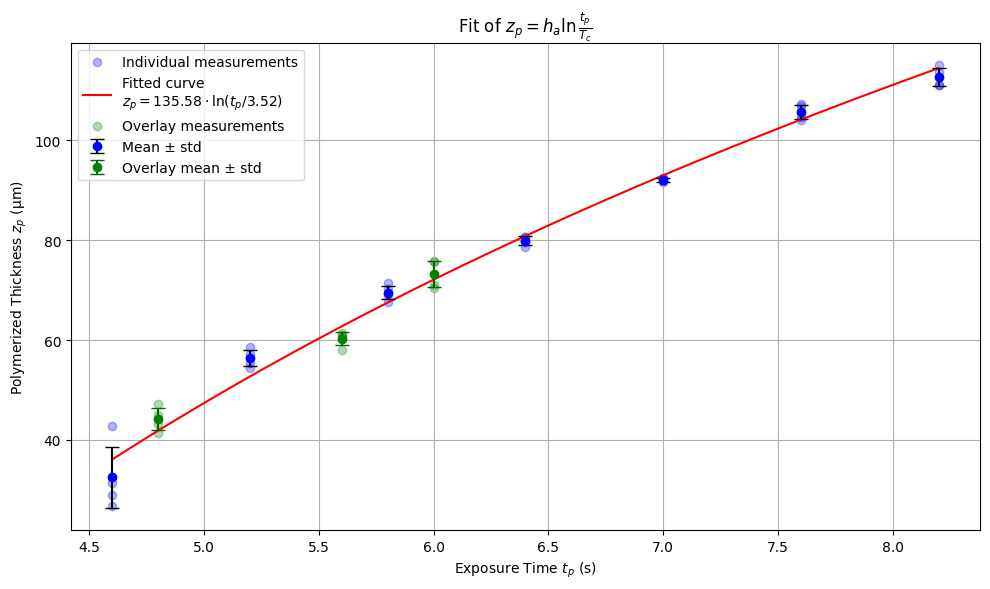


Model Deviations for Elegoo ABS-like (Training Data):
 Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  Absolute Deviation (µm)  Relative Deviation (%)
              8.20              112.76                 114.48                     1.72                    1.53
              7.60              105.74                 104.18                    -1.56                   -1.48
              7.00               92.11                  93.03                     0.92                    1.00
              6.40               79.93                  80.88                     0.96                    1.20
              5.80               69.53                  67.54                    -2.00                   -2.87
              5.20               56.38                  52.73                    -3.65                   -6.48
              4.60               32.49                  36.11                     3.62                   11.14

Training Data RMSE: 2.32 µm

Model Deviations for Elegoo

(   Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  \
 0                8.2            112.7625             114.483057   
 1                7.6            105.7425             104.181263   
 2                7.0             92.1150              93.031829   
 3                6.4             79.9275              80.882655   
 4                5.8             69.5350              67.536637   
 5                5.2             56.3850              52.731937   
 6                4.6             32.4900              36.110121   
 
    Absolute Deviation (µm)  Relative Deviation (%)  
 0                 1.720557                1.525824  
 1                -1.561237               -1.476451  
 2                 0.916829                0.995309  
 3                 0.955155                1.195027  
 4                -1.998363               -2.873895  
 5                -3.653063               -6.478784  
 6                 3.620121               11.142262  ,
 (   Exposure Time (s

In [5]:
elegoo_abs_csv_path = "../qupath/exp_calibration/elegoo_abs_4.0-8.2s/measurements.csv"
elegoo_abs_measured_zp_data = load_measured_zp_data_from_csv(elegoo_abs_csv_path)
elegoo_abs_exposure_times = np.array([8.2, 7.6, 7.0, 6.4, 5.8, 5.2, 4.6]) # sample 1-7 worked

elegoo_abs_vali_data_csv_path = "../qupath/evaluation/elegoo_abs_3.6_6.8/measurements.csv"
elegoo_abs_vali_measured_zp_data = load_measured_zp_data_from_csv(elegoo_abs_vali_data_csv_path)
elegoo_abs_vali_exposure_times = np.array([6.0, 5.6, 4.8]) # sample 1-6 worked

elegoo_abs_measured_zp_means = np.mean(elegoo_abs_measured_zp_data, axis=1)
elegoo_abs_vali_measured_zp_means = np.mean(elegoo_abs_vali_measured_zp_data, axis=1)
ha, Tc = fit_ha_Tc(elegoo_abs_exposure_times, elegoo_abs_measured_zp_means)
print(f"Fitted ha (Elegoo ABS-like): {ha:.2f} µm")
print(f"Fitted Tc (Elegoo ABS-like): {Tc:.3f} s")

plot_fit_with_error_bars(elegoo_abs_exposure_times, elegoo_abs_measured_zp_data, ha, Tc,
                        overlay_exposure_times=elegoo_abs_vali_exposure_times,
                        overlay_zp_data=elegoo_abs_vali_measured_zp_data)

print_model_deviations(elegoo_abs_exposure_times, elegoo_abs_measured_zp_data, ha, Tc,
                      elegoo_abs_vali_exposure_times, elegoo_abs_vali_measured_zp_data,
                      resin_name="Elegoo ABS-like")

### Anycubic Standad Clear

Fitted ha (Anycubic Standard Clear): 81.72 µm
Fitted Tc (Anycubic Standard Clear): 0.756 s


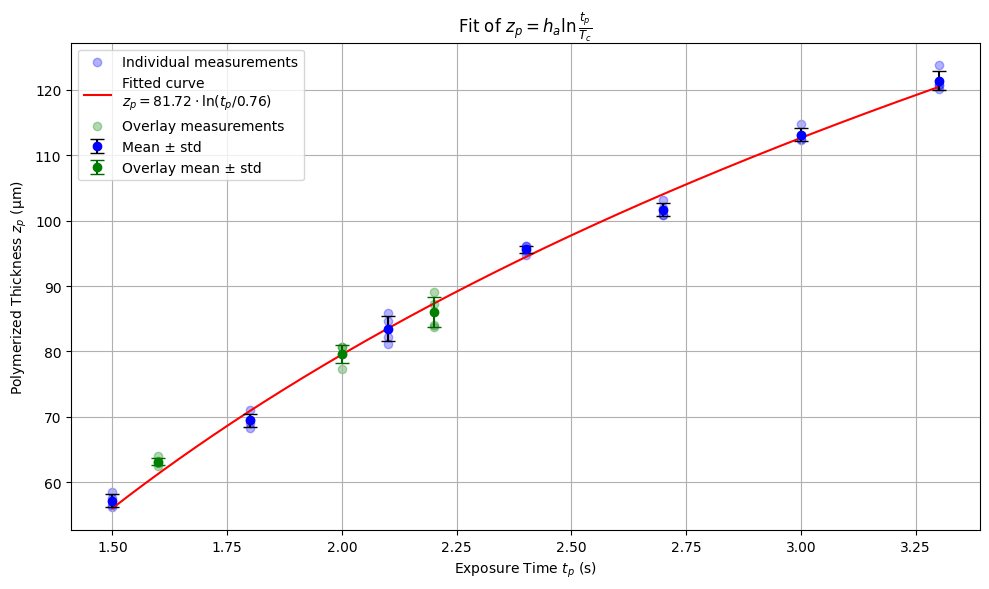


Model Deviations for Anycubic Standard Clear (Training Data):
 Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  Absolute Deviation (µm)  Relative Deviation (%)
              3.30              121.39                 120.45                    -0.95                   -0.78
              3.00              113.16                 112.66                    -0.51                   -0.45
              2.70              101.69                 104.05                     2.35                    2.31
              2.40               95.60                  94.42                    -1.18                   -1.23
              2.10               83.48                  83.51                     0.03                    0.03
              1.80               69.48                  70.91                     1.44                    2.07
              1.50               57.19                  56.01                    -1.18                   -2.06

Training Data RMSE: 1.28 µm

Model Deviations fo

(   Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  \
 0                3.3            121.3925             120.445849   
 1                3.0            113.1650             112.657121   
 2                2.7            101.6950             104.047083   
 3                2.4             95.6025              94.421879   
 4                2.1             83.4825              83.509722   
 5                1.8             69.4775              70.912562   
 6                1.5             57.1925              56.013284   
 
    Absolute Deviation (µm)  Relative Deviation (%)  
 0                -0.946651               -0.779827  
 1                -0.507879               -0.448795  
 2                 2.352083                2.312880  
 3                -1.180621               -1.234927  
 4                 0.027222                0.032608  
 5                 1.435062                2.065506  
 6                -1.179216               -2.061837  ,
 (   Exposure Time (s

In [6]:
anycubic_stadard_clear_csv_path = "../qupath/exp_calibration/anycubic_standard_clear_1.2-3.3s/measurements.csv"
anycubic_stadard_clear_measured_zp_data = load_measured_zp_data_from_csv(anycubic_stadard_clear_csv_path)
anycubic_stadard_clear_exposure_times = np.array([3.3, 3.0, 2.7, 2.4, 2.1, 1.8, 1.5]) # sample 1-7 worked

anycubic_stadard_clear_vali_csv_path = "../qupath/evaluation/anycubic_standard_clear_1.2-2.6/measurements.csv"
anycubic_stadard_clear_vali_measured_zp_data = load_measured_zp_data_from_csv(anycubic_stadard_clear_vali_csv_path)
anycubic_stadard_clear_vali_exposure_times = np.array([2.2, 2.0, 1.6]) # sample 1-6 worked

anycubic_stadard_clear_measured_zp_means = np.mean(anycubic_stadard_clear_measured_zp_data, axis=1)
anycubic_stadard_clear_vali_measured_zp_means = np.mean(anycubic_stadard_clear_vali_measured_zp_data, axis=1)
ha, Tc = fit_ha_Tc(anycubic_stadard_clear_exposure_times, anycubic_stadard_clear_measured_zp_means)
print(f"Fitted ha (Anycubic Standard Clear): {ha:.2f} µm")
print(f"Fitted Tc (Anycubic Standard Clear): {Tc:.3f} s")

plot_fit_with_error_bars(anycubic_stadard_clear_exposure_times, anycubic_stadard_clear_measured_zp_data, ha, Tc,
                        overlay_exposure_times=anycubic_stadard_clear_vali_exposure_times,
                        overlay_zp_data=anycubic_stadard_clear_vali_measured_zp_data)

print_model_deviations(anycubic_stadard_clear_exposure_times, anycubic_stadard_clear_measured_zp_data, ha, Tc,
                      anycubic_stadard_clear_vali_exposure_times, anycubic_stadard_clear_vali_measured_zp_data,
                      resin_name="Anycubic Standard Clear")

Fitted ha (Siraya Sculpt Clear): 119.69 µm
Fitted Tc (Siraya Sculpt Clear): 1.115 s


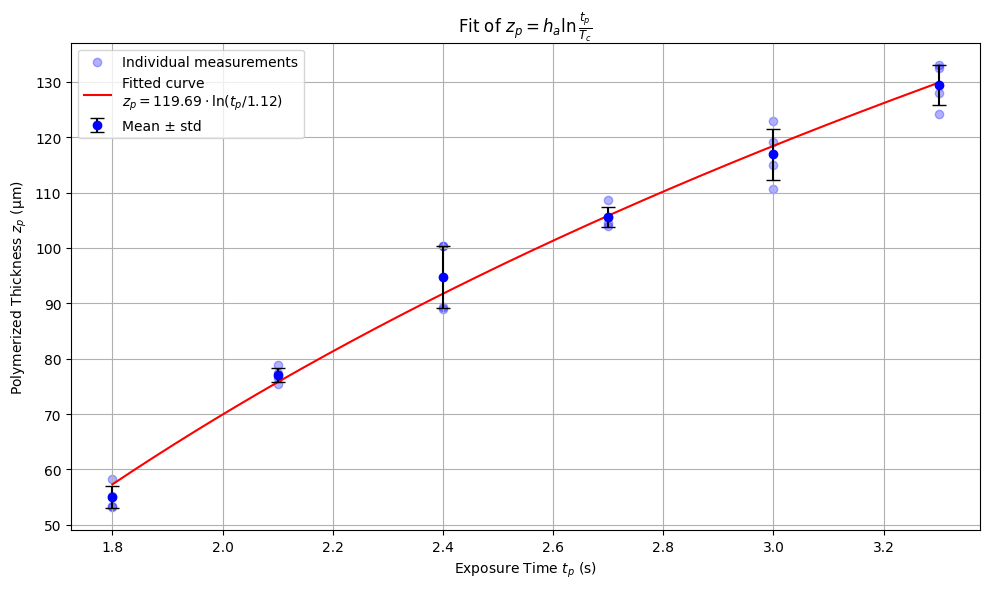


Model Deviations for Siraya Sculpt Clear (Training Data):
 Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  Absolute Deviation (µm)  Relative Deviation (%)
              3.30              129.46                 129.85                     0.39                    0.30
              3.00              116.91                 118.44                     1.53                    1.30
              2.70              105.66                 105.83                     0.16                    0.15
              2.40               94.78                  91.73                    -3.05                   -3.21
              2.10               77.06                  75.75                    -1.31                   -1.70
              1.80               55.01                  57.30                     2.28                    4.15

Training Data RMSE: 1.77 µm


(   Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  \
 0                3.3            129.4600             129.845227   
 1                3.0            116.9125             118.437655   
 2                2.7            105.6650             105.827169   
 3                2.4             94.7750              91.729845   
 4                2.1             77.0600              75.747617   
 5                1.8             55.0125              57.297489   
 
    Absolute Deviation (µm)  Relative Deviation (%)  
 0                 0.385227                0.297564  
 1                 1.525155                1.304527  
 2                 0.162169                0.153474  
 3                -3.045155               -3.213037  
 4                -1.312383               -1.703067  
 5                 2.284989                4.153581  ,
 np.float64(1.7662243232823696))

In [7]:
siraya_sculpt_clear_csv_path = "../qupath/exp_calibration/siraya_sculpt_clear_1.2-3.3s/measurements.csv"
siraya_sculpt_clear_measured_zp_data = load_measured_zp_data_from_csv(siraya_sculpt_clear_csv_path)
siraya_sculpt_clear_exposure_times = np.array([3.3, 3.0, 2.7, 2.4, 2.1, 1.8]) # samples 1-6 worked

siraya_sculpt_clear_measured_zp_means = np.mean(siraya_sculpt_clear_measured_zp_data, axis=1)
ha, Tc = fit_ha_Tc(siraya_sculpt_clear_exposure_times, siraya_sculpt_clear_measured_zp_means)
print(f"Fitted ha (Siraya Sculpt Clear): {ha:.2f} µm")
print(f"Fitted Tc (Siraya Sculpt Clear): {Tc:.3f} s")

plot_fit_with_error_bars(siraya_sculpt_clear_exposure_times, siraya_sculpt_clear_measured_zp_data, ha, Tc)

print_model_deviations(siraya_sculpt_clear_exposure_times, siraya_sculpt_clear_measured_zp_data, ha, Tc,
                      resin_name="Siraya Sculpt Clear")

Fitted ha (Frozen Speed Gray): 122.78 µm
Fitted Tc (Frozen Speed Gray): 0.667 s


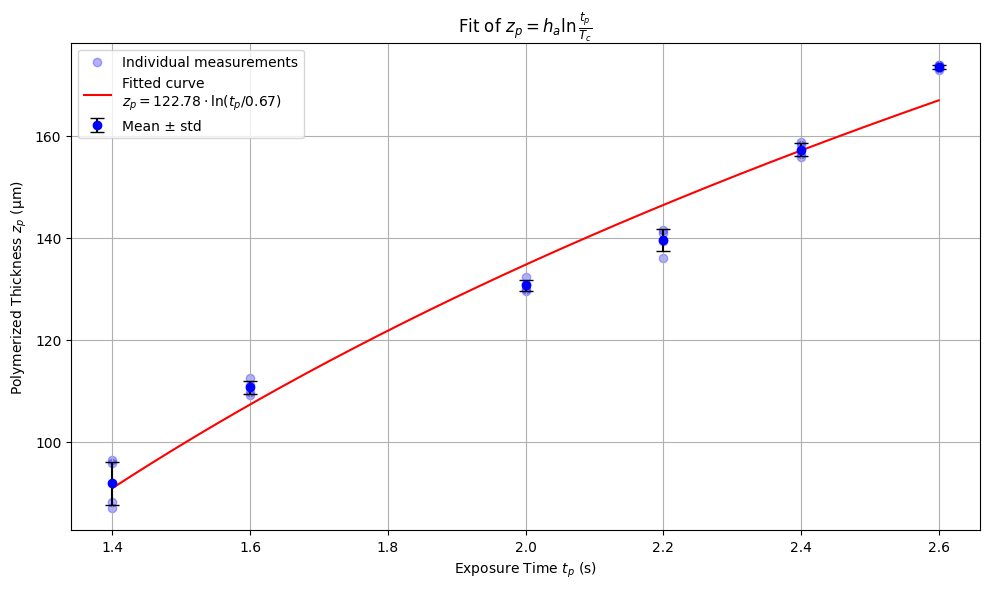


Model Deviations for Frozen Speed Gray (Training Data):
 Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  Absolute Deviation (µm)  Relative Deviation (%)
              2.60              173.48                 166.94                    -6.53                   -3.77
              2.40              157.28                 157.12                    -0.16                   -0.10
              2.20              139.48                 146.43                     6.95                    4.98
              2.00              130.71                 134.73                     4.02                    3.08
              1.60              110.67                 107.34                    -3.34                   -3.02
              1.40               91.88                  90.94                    -0.94                   -1.02

Training Data RMSE: 4.46 µm


(   Exposure Time (s)  Measured Mean (µm)  Model Prediction (µm)  \
 0                2.6            173.4775             166.944808   
 1                2.4            157.2775             157.117366   
 2                2.2            139.4825             146.434328   
 3                2.0            130.7125             134.732384   
 4                1.6            110.6725             107.335381   
 5                1.4             91.8825              90.940733   
 
    Absolute Deviation (µm)  Relative Deviation (%)  
 0                -6.532692               -3.765729  
 1                -0.160134               -0.101816  
 2                 6.951828                4.984015  
 3                 4.019884                3.075363  
 4                -3.337119               -3.015310  
 5                -0.941767               -1.024969  ,
 np.float64(4.4574353778505))

In [8]:
frozen_speed_gray_csv_path = "../qupath/exp_calibration/frozen_speed_gray_1.2-2.6s/measurements.csv"
frozen_speed_gray_measured_zp_data = load_measured_zp_data_from_csv(frozen_speed_gray_csv_path)
frozen_speed_gray_exposure_times = np.array([2.6, 2.4, 2.2, 2.0, 1.6, 1.4]) # samples 1-4, 6, 7 worked

frozen_speed_gray_measured_zp_means = np.mean(frozen_speed_gray_measured_zp_data, axis=1)
ha, Tc = fit_ha_Tc(frozen_speed_gray_exposure_times, frozen_speed_gray_measured_zp_means)
print(f"Fitted ha (Frozen Speed Gray): {ha:.2f} µm")
print(f"Fitted Tc (Frozen Speed Gray): {Tc:.3f} s")

plot_fit_with_error_bars(frozen_speed_gray_exposure_times, frozen_speed_gray_measured_zp_data, ha, Tc)

print_model_deviations(frozen_speed_gray_exposure_times, frozen_speed_gray_measured_zp_data, ha, Tc,
                      resin_name="Frozen Speed Gray")